In [2]:
import pandas as pd

In [9]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [6]:
train

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5
...,...,...,...,...,...,...,...,...,...,...,...,...
29446,Owner,0,0,3,BHK,2500.000000,1,1,"Shamshabad Road,Agra",27.140626,78.043277,45.0
29447,Owner,0,0,2,BHK,769.230769,1,1,"E3-108, Lake View Recidency,,Vapi",39.945409,-86.150721,16.0
29448,Dealer,0,0,2,BHK,1022.641509,1,1,"Ajmer Road,Jaipur",26.928785,75.828002,27.1
29449,Owner,0,0,2,BHK,927.079009,1,1,"Sholinganallur,Chennai",12.900150,80.227910,67.0


In [7]:
"""
tes Description:
Column	Description
POSTED_BY	Category marking who has listed the property
UNDER_CONSTRUCTION	Under Construction or Not
RERA	Rera approved or Not
BHK_NO	Number of Rooms
BHK_OR_RK	Type of property
SQUARE_FT	Total area of the house in square feet
READY_TO_MOVE	Category marking Ready to move or Not
RESALE	Category marking Resale or not
ADDRESS	Address of the property
LONGITUDE	Longitude of the property
LATITUDE	Latitude of the property
"""
train.columns

Index(['POSTED_BY', 'UNDER_CONSTRUCTION', 'RERA', 'BHK_NO.', 'BHK_OR_RK',
       'SQUARE_FT', 'READY_TO_MOVE', 'RESALE', 'ADDRESS', 'LONGITUDE',
       'LATITUDE', 'TARGET(PRICE_IN_LACS)'],
      dtype='object')

In [10]:
sample_submission

,TARGET(PRICE_IN_LACS)
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
68715,0.0
68716,0.0
68717,0.0
68718,0.0


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Определение списков признаков глобально
CATEGORICAL_FEATURES = ['POSTED_BY', 'BHK_OR_RK']
NUMERICAL_FEATURES = ['UNDER_CONSTRUCTION', 'RERA', 'BHK_NO.', 
                     'SQUARE_FT', 'READY_TO_MOVE', 'RESALE',
                     'LONGITUDE', 'LATITUDE']

def preprocess_data(df):
    # Удаление ненужных столбцов
    df = df.drop(['ADDRESS'], axis=1)
    
    # Создание преобразователя
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(), CATEGORICAL_FEATURES),
            ('num', 'passthrough', NUMERICAL_FEATURES)
        ])
    
    # Получение имен признаков после преобразования
    transformed_data = preprocessor.fit_transform(df)
    feature_names = preprocessor.get_feature_names_out()
    
    return transformed_data, feature_names

# Подготовка данных
X, feature_names = preprocess_data(train.drop('TARGET(PRICE_IN_LACS)', axis=1))
y = train['TARGET(PRICE_IN_LACS)']

In [14]:
# Создание модели
model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

# Кросс-валидация на 5 фолдах
cv = KFold(n_splits=5, shuffle=True, random_state=42)
y_pred = cross_val_predict(model, X, y, cv=cv)

In [15]:
# Оценка качества
print(f"MSE: {mean_squared_error(y, y_pred):.2f}")
print(f"MAE: {mean_absolute_error(y, y_pred):.2f}")
print(f"R²: {r2_score(y, y_pred):.4f}")

MSE: 43517.32
MAE: 37.34
R²: 0.8991


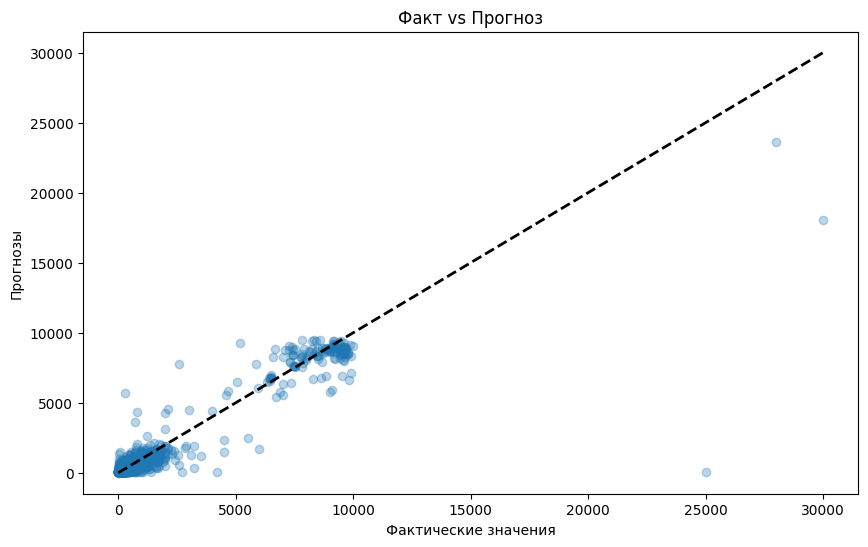

In [16]:
# Визуализация прогнозов
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Фактические значения')
plt.ylabel('Прогнозы')
plt.title('Факт vs Прогноз')
plt.show()

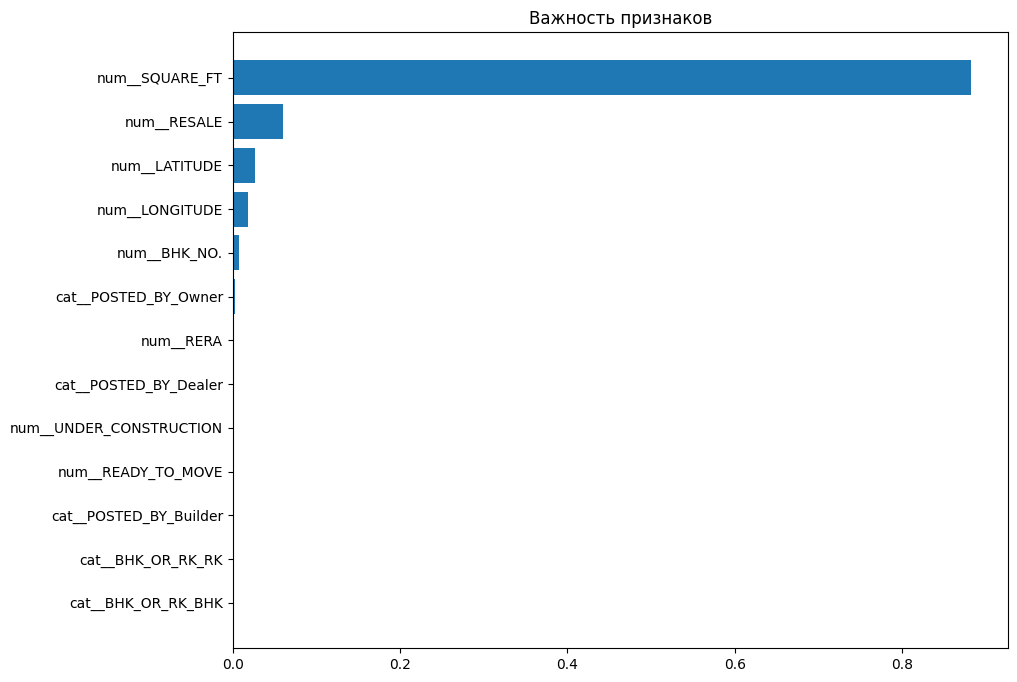

In [17]:
# Важность признаков
model.fit(X, y)
importances = model.feature_importances_
sorted_idx = np.argsort(importances)

plt.figure(figsize=(10, 8))
plt.barh(range(len(importances)), importances[sorted_idx], align='center')
plt.yticks(range(len(importances)), feature_names[sorted_idx])
plt.title('Важность признаков')
plt.show()

In [18]:
# Генерация прогнозов для тестовых данных
X_test, _ = preprocess_data(test)
test_pred = model.predict(X_test)

# Сохранение результатов
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['TARGET(PRICE_IN_LACS)'] = test_pred
sample_submission.to_csv('submission.csv', index=False)